<a href="https://colab.research.google.com/github/sholtodouglas/learning_from_play/blob/master/notebooks/languageXplay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install package dependencies (forces restart)
import os

def restart_runtime():
    print('Runtime restarting...')
    os.kill(os.getpid(), 9)
    
!git clone 'https://github.com/sholtodouglas/pandaRL' 'local_packages/pandaRL'
!pip install -e 'local_packages/pandaRL/.'

restart_runtime()

In [1]:
!pip -q install pybullet wandb

     |████████████████████████████████| 76.6MB 92kB/s 
     |████████████████████████████████| 1.9MB 61.3MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
     |████████████████████████████████| 163kB 60.0MB/s 
     |████████████████████████████████| 102kB 11.7MB/s 
     |████████████████████████████████| 133kB 60.5MB/s 
     |████████████████████████████████| 71kB 8.9MB/s 


In [1]:
# Config
config = {
    'colab':False,
    'gcs':False,
    'device':'GPU', # 'CPU', 'GPU', 'TPU'
    'train_datasets':["UR5"],
    'test_datasets':["UR5_slow_gripper_test"],
    # data
    'batch_size':32,
    # model
    'layer_size':256,
    'latent_dim':256,
    'gcbc':False,
    'num_distribs':None,
    'qbits':None,
    # training
    'learning_rate':3e-4,
}

In [2]:
#@title Workpace Setup (Local vs Colab)
from pathlib import Path
import os

# COLAB = False #@param {type:"boolean"}
AUTH_GCS = False #@param {type:"boolean"}
# DEVICE = "CPU" #@param ["TPU", "GPU", "CPU"]
DATA_SOURCE = "Google Drive" #@param ["Google Drive", "GCS"]
# TRAIN_DATASETS = ["UR5"]#,"UR5_slow_gripper","UR5_high_transition"]
# TEST_DATASET = "UR5_slow_gripper_test" #@param ["UR5_slow_gripper_test"]
GCS_USER = "sholto" #@param ["sholto", "tristan"]

if config['colab']:
    from google.colab import drive, auth
    print('Using colab setup')
    !git clone 'https://github.com/sholtodouglas/learning_from_play'
    WORKING_PATH = Path('/content/learning_from_play')
    drive.mount('/content/drive')
    os.chdir(WORKING_PATH)
    STORAGE_PATH = Path('/content/drive/My Drive/Robotic Learning')
    print(f'Storage path: {STORAGE_PATH}')
else:
    print('Using local setup')
    WORKING_PATH = Path().absolute().parent
    print(f'Working path: {WORKING_PATH}')
    os.chdir(WORKING_PATH)
    STORAGE_PATH = WORKING_PATH
    print(f'Storage path: {STORAGE_PATH}')

TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in config['train_datasets']]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in config['test_datasets']]

Using local setup
Working path: /home/sholto/Desktop/AI/learning_from_play
Storage path: /home/sholto/Desktop/AI/learning_from_play


# Data Creation

In [3]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

if config['device'] == "TPU":
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    NUM_DEVICES = strategy.num_replicas_in_sync
    print("REPLICAS: ", NUM_DEVICES)
else:
    physical_devices = tf.config.list_physical_devices()
    if config['device'] == 'GPU':
        tf.config.experimental.set_memory_growth(physical_devices[3], enable=True)
    NUM_DEVICES = 1
    print(physical_devices)

Tensorflow version 2.3.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Dataset

In [4]:
import glob
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
from collections import Counter
import random
import datetime

import lfp
from natsort import natsorted

In [5]:
# Use this to edit modules without needing to restart the kernel
import importlib
importlib.reload(lfp.data)
importlib.reload(lfp.model)
importlib.reload(lfp.train)

<module 'lfp.train' from '/home/sholto/Desktop/AI/learning_from_play/lfp/train.py'>

### Config Flags

In [6]:
GLOBAL_BATCH_SIZE = config['batch_size'] * NUM_DEVICES
dl = lfp.data.PlayDataloader(batch_size=GLOBAL_BATCH_SIZE)

In [7]:
# Train data
train_data = dl.extract(TRAIN_DATA_PATHS)
train_dataset = dl.load(train_data)

UR5: 100%|██████████| 52/52 [00:00<00:00, 70.35it/s]


{   'acts': TensorSpec(shape=(32, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(32, None, 1), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(32, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(32, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(32, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(32,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(32, None, 1), dtype=tf.int32, name=None)}


In [9]:
# Validation data
valid_data = dl.extract(TEST_DATA_PATHS)
valid_dataset = dl.load(valid_data)

UR5_slow_gripper_test: 100%|██████████| 2/2 [00:00<00:00, 53.82it/s]

{   'acts': TensorSpec(shape=(32, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(32, None, 1), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(32, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(32, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(32, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(32,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(32, None, 1), dtype=tf.int32, name=None)}


# Model

## LSTM Model
Use this to map obs -> act

In [10]:
model_params = {'obs_dim':dl.obs_dim,
                'goal_dim':dl.goal_dim,
                'act_dim':dl.act_dim,
                'layer_size':config['layer_size'], 
                'latent_dim':config['latent_dim']}
actor = lfp.model.create_actor(**model_params, gcbc=config['gcbc'], num_distribs=config['num_distribs'])

In [11]:
encoder = lfp.model.create_encoder(**model_params)
planner = lfp.model.create_planner(**model_params)

# Training Loop

In [19]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import Progbar
import tensorflow_addons as tfa

import time
import io
import wandb
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /Users/Tristan/.netrc


True

In [19]:
from lfp.metric import MaxMetric
from lfp.train import LFPTrainer

In [24]:
def train_setup():
    model_params = {'obs_dim':dl.obs_dim,
                'goal_dim':dl.goal_dim,
                'act_dim':dl.act_dim,
                'layer_size':config['layer_size'], 
                'latent_dim':config['latent_dim']}
    
    actor = lfp.model.create_actor(**model_params, gcbc=config['gcbc'], num_distribs=config['num_distribs'])

    if config['gcbc']:
        encoder = None
        planner = None
    else:
        encoder = lfp.model.create_encoder(**model_params)
        planner = lfp.model.create_planner(**model_params)

    optimizer = tf.optimizers.Adam(learning_rate=config['learning_rate'])
    trainable_variables = actor.trainable_variables + encoder.trainable_variables + planner.trainable_variables

if config['device']=='CPU':
    train_setup()
else:
    with strategy.scope():
        train_setup()
        
train_dist_dataset = iter(strategy.experimental_distribute_dataset(train_dataset))
valid_dist_dataset = iter(strategy.experimental_distribute_dataset(valid_dataset))

In [31]:
with strategy.scope():
    nll_action_loss = lambda y, p_y: tf.reduce_sum(-p_y.log_prob(y), axis=2)
    mae_action_loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
    mse_action_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

    def compute_loss(labels, predictions, mask, seq_lens, weightings=None):
        if PROBABILISTIC:
            per_example_loss = nll_action_loss(labels, predictions) * mask
        else:
            per_example_loss = mae_action_loss(labels, predictions) * mask

        per_example_loss = tf.reduce_sum(per_example_loss, axis=1) / seq_lens  # take mean along the timestep
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)


    def compute_MAE(labels, predictions, mask, seq_lens, weightings=None):
        per_example_loss = mae_action_loss(labels, predictions) * mask
        per_example_loss = tf.reduce_sum(per_example_loss, axis=1) / seq_lens  # take mean along the timestep
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)


    def compute_regularisation_loss(plan, encoding):
        # Reverse KL(enc|plan): we want planner to map to encoder (weighted by encoder)
        reg_loss = tfd.kl_divergence(encoding, plan)  # + KL(plan, encoding)
        return tf.nn.compute_average_loss(reg_loss, global_batch_size=GLOBAL_BATCH_SIZE)


    train_loss = tf.keras.metrics.Mean(name='train_loss')
    valid_loss = tf.keras.metrics.Mean(name='valid_loss')
    actor_grad_norm = tf.keras.metrics.Mean(name='actor_grad_norm')
    encoder_grad_norm = tf.keras.metrics.Mean(name='encoder_grad_norm')
    planner_grad_norm = tf.keras.metrics.Mean(name='planner_grad_norm')

    actor_grad_norm_clipped = tf.keras.metrics.Mean(name='actor_grad_norm_clipped')
    encoder_grad_norm_clipped = tf.keras.metrics.Mean(name='encoder_grad_norm_clipped')
    planner_grad_norm_clipped = tf.keras.metrics.Mean(name='planner_grad_norm_clipped')

    global_grad_norm = tf.keras.metrics.Mean(name='global_grad_norm')

    test = tf.keras.metrics.Mean(name='test')
    test2 = tf.keras.metrics.Mean(name='test2')

    train_act_with_enc_loss = tf.keras.metrics.Mean(name='train_act_with_enc_loss')
    train_act_with_plan_loss = tf.keras.metrics.Mean(name='train_act_with_plan_loss')
    valid_act_with_enc_loss = tf.keras.metrics.Mean(name='valid_act_with_enc_loss')
    valid_act_with_plan_loss = tf.keras.metrics.Mean(name='valid_act_with_plan_loss')

    train_reg_loss = tf.keras.metrics.Mean(name='reg_loss')
    valid_reg_loss = tf.keras.metrics.Mean(name='valid_reg_loss')
    if INFO_VAE:
        train_mmd_reg_loss = tf.keras.metrics.Mean(name='train_mmd_reg_loss')
        valid_mmd_reg_loss = tf.keras.metrics.Mean(name='valid_mmd_reg_loss')

    valid_position_loss = tf.keras.metrics.Mean(name='valid_position_loss')
    valid_max_position_loss = MaxMetric(name='valid_max_position_loss')
    valid_rotation_loss = tf.keras.metrics.Mean(name='valid_rotation_loss')
    valid_max_rotation_loss = MaxMetric(name='valid_max_rotation_loss')
    valid_gripper_loss = tf.keras.metrics.Mean(name='valid_rotation_loss')

    model_params = {'layer_size': LAYER_SIZE, 'latent_dim': LATENT_DIM}
    if PROBABILISTIC:
        actor = create_actor(**model_params, GCBC=GCBC, num_distribs=3)

    else:
        actor = create_actor(**model_params, GCBC=GCBC)

    actor_grad_len = len(actor.trainable_variables)
    if GCBC:
        encoder = None
        planner = None
    else:
        encoder = create_encoder(**model_params)
        planner = create_planner(**model_params)
        encoder_grad_len = len(encoder.trainable_variables)
        planner_grad_len = len(planner.trainable_variables)

    optimizer = tf.optimizers.Adam(learning_rate=3e-4)
    trainable_variables = actor.trainable_variables + encoder.trainable_variables + planner.trainable_variables
    checkpoint = tf.train.Checkpoint(encoder=encoder,
                                     planner=planner,
                                     actor=actor,
                                     optimizer=optimizer)


# Now outside strategy .scope
def train_step(inputs, beta, prev_global_grad_norm):
    with tf.GradientTape() as tape, tf.GradientTape() as planner_tape:  # separate planner tape for INFO VAE
        # Todo: figure out mask and seq_lens for new dataset 
        states, actions, goals, seq_lens, mask = inputs['obs'], inputs['acts'], inputs['goals'], inputs['seq_lens'], \
                                                 inputs['masks']
        action_weights = (dataloader.act_dim - 1) * [1.0] + [GRIPPER_WEIGHT]  # 1 for all but gripper
        if GCBC:
            distrib = actor([states, goals])
            loss = compute_loss(actions, distrib, mask, seq_lens, weightings=action_weights)
            gradients = tape.gradient(loss, actor.trainable_variables)
            optimizer.apply_gradients(zip(gradients, actor.trainable_variables))
        else:
            encoding = encoder([states, actions])
            plan = planner([states[:, 0, :], goals[:, 0,
                                             :]])  # the final goals are tiled out over the entire non masked sequence, so the first timestep is the final goal. 
            z_enc = encoding.sample()
            z_plan = plan.sample()
            z_enc_tiled = tf.tile(tf.expand_dims(z_enc, 1), (1, dataloader.window_size, 1))
            z_plan_tiled = tf.tile(tf.expand_dims(z_plan, 1), (1, dataloader.window_size, 1))

            enc_policy = actor([states, z_enc_tiled, goals])
            plan_policy = actor([states, z_plan_tiled, goals])

            act_enc_loss = compute_loss(actions, enc_policy, mask, seq_lens, weightings=action_weights)
            act_plan_loss = compute_loss(actions, plan_policy, mask, seq_lens, weightings=action_weights)
            act_loss = act_enc_loss

            if INFO_VAE:
                true_samples = tf.keras.backend.random_normal(tf.stack([z_enc.shape[0], LATENT_DIM]))
                reg_loss = compute_mmd(true_samples, z_enc)
                train_mmd_reg_loss.update_state(reg_loss)
                plan_chase_enc = compute_regularisation_loss(plan, encoding)
                train_reg_loss.update_state(plan_chase_enc)
            else:
                reg_loss = compute_regularisation_loss(plan, encoding)
                train_reg_loss.update_state(reg_loss)
            train_act_with_enc_loss.update_state(act_enc_loss)
            train_act_with_plan_loss.update_state(act_plan_loss)

            loss = act_loss + reg_loss * beta

            if INFO_VAE:
                gradients = tape.gradient(loss, actor.trainable_variables + encoder.trainable_variables)
                optimizer.apply_gradients(zip(gradients, actor.trainable_variables + encoder.trainable_variables))
                gradients = planner_tape.gradient(plan_chase_enc, planner.trainable_variables)
                optimizer.apply_gradients(zip(gradients, planner.trainable_variables))

            else:

                gradients = tape.gradient(loss, trainable_variables)
                # print(gradients)
                actor_norm = tf.linalg.global_norm(gradients[:actor_grad_len])
                encoder_norm = tf.linalg.global_norm(gradients[actor_grad_len:actor_grad_len + encoder_grad_len])
                planner_norm = tf.linalg.global_norm(
                    gradients[actor_grad_len + encoder_grad_len:actor_grad_len + encoder_grad_len + planner_grad_len])
                actor_grad_norm.update_state(actor_norm)
                encoder_grad_norm.update_state(encoder_norm)
                planner_grad_norm.update_state(planner_norm)

                # scale planner gradients

                # if the gradient norm is more than 3x the previous one, clip it to the previous norm for stability
                gradients = tf.cond(tf.linalg.global_norm(gradients) > 3 * prev_global_grad_norm,
                                    lambda: tf.clip_by_global_norm(gradients, prev_global_grad_norm)[0],
                                    lambda: gradients)  # must get[0] as it returns new norm as [1]
                # gradients = tf.cond(sum_of_norms > 3*prev_global_grad_norm, lambda: [tf.clip_by_norm(g, prev_global_grad_norm) for g in gradients], lambda: gradients)
                # test2.update_state(tf.linalg.global_norm(gradients))
                # test.update_state(tf.linalg.global_norm(gradients[actor_grad_len+encoder_grad_len:actor_grad_len+encoder_grad_len+planner_grad_len]))
                # make the planner converge more quickly
                planner_grads = gradients[
                                actor_grad_len + encoder_grad_len:actor_grad_len + encoder_grad_len + planner_grad_len]

                planner_grads = [g * 10 for g in planner_grads]
                gradients = gradients[:actor_grad_len] + gradients[
                                                         actor_grad_len:actor_grad_len + encoder_grad_len] + planner_grads
                # test2.update_state(tf.linalg.global_norm(gradients[actor_grad_len+encoder_grad_len:actor_grad_len+encoder_grad_len+planner_grad_len]))

                actor_norm_clipped = tf.linalg.global_norm(gradients[:actor_grad_len])
                encoder_norm_clipped = tf.linalg.global_norm(
                    gradients[actor_grad_len:actor_grad_len + encoder_grad_len])
                planner_norm_clipped = tf.linalg.global_norm(
                    gradients[actor_grad_len + encoder_grad_len:actor_grad_len + encoder_grad_len + planner_grad_len])
                actor_grad_norm_clipped.update_state(actor_norm_clipped)
                encoder_grad_norm_clipped.update_state(encoder_norm_clipped)
                planner_grad_norm_clipped.update_state(planner_norm_clipped)

                global_grad_norm.update_state(tf.linalg.global_norm(gradients))

                optimizer.apply_gradients(zip(gradients,
                                              actor.trainable_variables + encoder.trainable_variables + planner.trainable_variables))

    train_loss.update_state(loss)

    return loss


def test_step(inputs, beta):
    states, actions, goals, seq_lens, mask = inputs['obs'], inputs['acts'], inputs['goals'], inputs['seq_lens'], inputs[
        'masks']
    action_weights = (dataloader.act_dim - 1) * [1.0] + [GRIPPER_WEIGHT]  # 1 for all but gripper
    if dataloader.quaternion_act:
        # xyz, q1-4, grip
        action_breakdown = [3, 4, 1]
    else:
        action_breakdown = [3, 3, 1]

    if GCBC:
        policy = actor([states, goals], training=False)
        loss = compute_loss(actions, policy, mask, seq_lens, weightings=action_weights)
        if PROBABILISTIC:
            pos_acts, rot_acts, grip_act = tf.split(policy.sample(), action_breakdown, -1)
        else:
            pos_acts, rot_acts, grip_act = tf.split(policy, action_breakdown, -1)
    else:
        encoding = encoder([states, actions])
        plan = planner([states[:, 0, :], goals[:, 0,
                                         :]])  # the final goals are tiled out over the entire non masked sequence, so the first timestep is the final goal. 
        z_enc = encoding.sample()
        z_plan = plan.sample()
        z_enc_tiled = tf.tile(tf.expand_dims(z_enc, 1), (1, dataloader.window_size, 1))
        z_plan_tiled = tf.tile(tf.expand_dims(z_plan, 1), (1, dataloader.window_size, 1))

        enc_policy = actor([states, z_enc_tiled, goals])
        plan_policy = actor([states, z_plan_tiled, goals])

        act_enc_loss = compute_loss(actions, enc_policy, mask, seq_lens, weightings=action_weights)
        act_plan_loss = compute_loss(actions, plan_policy, mask, seq_lens, weightings=action_weights)
        act_loss = act_plan_loss

        if INFO_VAE:
            true_samples = tf.keras.backend.random_normal(tf.stack([z_enc.shape[0], LATENT_DIM]))
            reg_loss = compute_mmd(true_samples, z_enc)
            valid_mmd_reg_loss.update_state(reg_loss)
            plan_chase_enc = compute_regularisation_loss(plan, encoding)
            valid_reg_loss.update_state(plan_chase_enc)
        else:
            reg_loss = compute_regularisation_loss(plan, encoding)
            valid_reg_loss.update_state(reg_loss)

        valid_act_with_enc_loss.update_state(act_enc_loss)
        valid_act_with_plan_loss.update_state(act_plan_loss)

        # pos, rot, gripper individual losses
        if PROBABILISTIC:
            pos_acts, rot_acts, grip_act = tf.split(plan_policy.sample(), action_breakdown, -1)
        else:
            pos_acts, rot_acts, grip_act = tf.split(plan_policy, action_breakdown, -1)

        loss = act_loss + reg_loss * beta

    true_pos_acts, true_rot_acts, true_grip_act = tf.split(actions, action_breakdown, -1)
    valid_position_loss.update_state(compute_MAE(true_pos_acts, pos_acts, mask, seq_lens))
    valid_max_position_loss(true_pos_acts, pos_acts, mask)
    valid_rotation_loss.update_state(compute_MAE(true_rot_acts, rot_acts, mask, seq_lens))
    valid_max_rotation_loss(true_rot_acts, rot_acts, mask)
    valid_gripper_loss.update_state(compute_MAE(true_grip_act, grip_act, mask, seq_lens))
    valid_loss.update_state(loss)

    if GCBC:
        return loss
    else:
        return loss, z_enc, z_plan


@tf.function
def distributed_train_step(dataset_inputs, beta, prev_global_grad_norm):
    per_replica_losses = strategy.run(train_step, args=(dataset_inputs, beta, prev_global_grad_norm))
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)


@tf.function
def distributed_test_step(dataset_inputs, beta):
    if GCBC:
        per_replica_losses = strategy.run(test_step, args=(dataset_inputs, beta))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)
    else:
        per_replica_losses, ze, zp = strategy.run(test_step, args=(dataset_inputs, beta))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None), ze.values[0], zp.values[0]

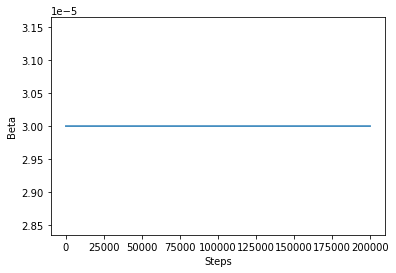

In [18]:
from lfp.train import BetaScheduler

TRAIN_STEPS = 200000
# 0.00001 so far works best for MAE - try lower - 0.00003 with a BETA accel of 10 so far works best, perfect encoder, nicely mapped planner
# recall 0.01 worked okay for probabilistic - proba still too unstable!
beta_sched = BetaScheduler('linear', 
                           beta=0.00003, 
                           beta_max=0.00003, 
                           max_steps=TRAIN_STEPS, 
                           cycles=90, 
                           duty_cycle=0.5
                           )

In [33]:
progbar = Progbar(TRAIN_STEPS, verbose=1, interval=0.5)
best_valid_loss = np.float('inf')

valid_inc = 20
save_inc = 1000

prev_grad_norm = np.float('inf')

In [36]:
RESUME = True
model_path

'/content/drive/My Drive/Robotic Learning/LMP_test/Tests/'

In [37]:
run_name = "Tests"#"ALLB0.00003"
model_path = f'/content/drive/My Drive/Robotic Learning/LMP_test/{run_name}/'

if RESUME:
  run_id = str(np.load(model_path+'hyper_params.npz')['run_id'])
  wandb.init(project="learning-from-play_v2", id='12621l2h',  resume="must")
  load_weights(model_path, actor, encoder, planner)
  load_optimizer_state(optimizer, model_path)
  print('Loaded model weights and optimiser state')
  t = wandb.run.step + valid_inc
else:
  wandb.init(project="learning-from-play_v2")
  wandb.run.name = run_name
  t = 0


valid_act_with_enc_loss_result,0.00251
train_act_with_plan_loss_result,0.00267
_runtime,246875
_timestamp,1611486306
beta_result,3e-05
train_loss_result,0.00039
valid_reg_loss_result,4.08413
valid_max_rotation_loss_result,3.55939
actor_grad_norm,0.03141
encoder_grad_norm_clipped,0.0009
valid_gripper_loss_result,0.01561


Loaded model weights and optimiser state


In [38]:
config = wandb.config

# Hparams
config.DEVICE = DEVICE
config.WINDOW_SIZE = dataloader.window_size
config.WINDOW_SHIFT = dataloader.window_shift
config.LAYER_SIZE = LAYER_SIZE
config.LATENT_DIM = LATENT_DIM
config.GRIPPER_WEIGHT = GRIPPER_WEIGHT
config.TRAIN_STEPS = TRAIN_STEPS
config.beta_schedule = beta_sched.schedule
config.beta_min = beta_sched.beta_min
config.beta_max = beta_sched.beta_max
config.PROBABILISTIC = PROBABILISTIC
config.PROPRIOCEPTION = dataloader.proprioception

In [55]:
from lfp.plotting import produce_cluster_fig, project_enc_and_plan, plot_to_image
v_it = iter(valid_dataset) #for the cluster fig, easier with a non distributed dataset

def log(metric):
  result = metric.result()
  metric.reset_states()
  return result

In [ ]:
while t < TRAIN_STEPS:
    start_time = time.time()
    beta = beta_sched.scheduler(t)
    x = next(train_dist_dataset)
    total_train_loss = distributed_train_step(x, beta, prev_grad_norm)
    
    if t % valid_inc == 0:  
        valid_x = next(valid_dist_dataset)
        if GCBC:
          total_val_loss = distributed_test_step(valid_x, beta)
        else:
          total_val_loss, ze, zp = distributed_test_step(valid_x, beta)

        # validation plotting
        progbar.add(valid_inc, [('Train Loss', train_loss.result()), ('Validation Loss', valid_loss.result()), ('Time (s)', round(time.time() - start_time, 1))])


        wandb.log({'train_loss_result':log(train_loss),
                    'valid_loss_result':log(valid_loss),
                    'valid_position_loss_result':log(valid_position_loss),
                    'valid_max_position_loss_result':log(valid_max_position_loss),
                    'valid_rotation_loss_result':log(valid_rotation_loss),
                    'valid_max_rotation_loss_result':log(valid_max_rotation_loss),
                    'valid_gripper_loss_result':log(valid_gripper_loss),
                    'actor_grad_norm': log(actor_grad_norm),
                    'actor_grad_norm_clipped': log(actor_grad_norm_clipped),
                  },
                  step=t)
          
        if not GCBC:
          wandb.log({
                      'train_act_with_enc_loss_result':log(train_act_with_enc_loss),
                      'train_act_with_plan_loss_result':log(train_act_with_plan_loss),
                      'train_reg_loss_result':log(train_reg_loss),
                      'valid_act_with_enc_loss_result':log(valid_act_with_enc_loss),
                      'valid_act_with_plan_loss_result':valid_act_with_plan_loss.result(),
                      'valid_reg_loss_result':log(valid_reg_loss),
                      'beta_result':beta,
                      'encoder_grad_norm': log(encoder_grad_norm),
                      'planner_grad_norm': log(planner_grad_norm),
                      'encoder_grad_norm_clipped': log(encoder_grad_norm_clipped),
                      'planner_grad_norm_clipped': log(planner_grad_norm_clipped),
                    },
                    step=t)
          

        prev_grad_norm = log(global_grad_norm)
          
    if t % save_inc == 0:
        save_weights(model_path, actor, encoder, planner)
        if not GCBC:
          z_enc, z_plan = produce_cluster_fig(next(v_it), encoder, planner, TEST_DATA_PATH, num_take=dataloader.batch_size)
          wandb.log({'z_enc':z_enc, 'z_plan':z_plan}, step=t)
          latent_fig = project_enc_and_plan(ze, zp)
          latent_img = plot_to_image(latent_fig)

    t += 1

   360/200000 [..............................] - ETA: 987:34:12 - Train Loss: 0.0099 - Validation Loss: 0.0132 - Time (s): 3.5722 